# Predicting Wind Turbine Yield

Dataset is available here: https://www.kaggle.com/datasets/psycon/wind-turbine-energy-kw-generation-data

Research Questions:
- What are the environmental conditions under which the wind turbine operates?
- When and why does the wind turbine absorb power?
- How often is the turbine limited by the wind, and how often by the grid?
- What is the cut-in and cut-out wind speed for this wind turbine?

Workflow:
- checking differences in output power between years: looking for year-to-year differences
- looking for a seasonal trend
- identifying correlations
- data cleaning

Methods:
- we can explore time-series based, but also other methods

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from math import ceil, floor
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from utils import remove_outliers_iqr

## Loading the data

In [3]:
feature_units = pd.read_csv("kaggle_dataset/feature_units.csv")
features = pd.read_csv("kaggle_dataset/features.csv", index_col="Timestamp")
features.index = pd.to_datetime(features.index)

power = pd.read_csv("kaggle_dataset/power.csv", index_col="Timestamp")
power.index = pd.to_datetime(power.index)

In [4]:
feature_units.shape, features.shape, power.shape

((77, 2), (154262, 76), (136730, 1))

In [5]:
features.index.min(), features.index.max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2021-12-14 23:50:00'))

In [6]:
dataset_days = round(features.index.shape[0] / (6*24))
print(f"This dataset consists of {dataset_days} days")

This dataset consists of 1071 days


## Data Cleaning
Time series methods might have different handling of outliers, as we cannot simply drop them

In [7]:
nans_per_feature = features.isna().sum()
nans_per_feature.loc[nans_per_feature > 5000]

Gearbox_Oil_Temperature                              5176
Moment D Direction                                   5231
Temperature Heat Exchanger Converter Control Unit    5186
Pitch Offset-1 Asymmetric Load Controller            5023
Wind Deviation 10 seconds                            5132
Proxy Sensor_Degree-135                              5337
Pitch Demand Baseline_Degree                         5188
Blade-1 Set Value_Degree                             5506
Moment Q Filltered                                   5160
dtype: int64

### Checking dtypes
All features are numerical, some might be continuous, some might be discrete.

In [9]:
sum(features.dtypes != float)

0

### Looking for duplicates

In [10]:
features.duplicated().sum()

0

### Looking for outliers

In [11]:
features_per_unit = feature_units.groupby('Unit').count().T
features_per_unit.columns

Index(['( )', '(%)', '()', '(Hz)', '(Nm)', '(V)', '(bar)', '(kNm)', '(kVAr)',
       '(kW)', '(mm)', '(mm/s²)', '(ms)', '(rpm)', '(°)', '(°C)'],
      dtype='object', name='Unit')

Temperatures in wind turbines do not reach 99999°C, these are missing values. After cleaning the temperatures seem realistic.

In [13]:
temperature_features = feature_units.loc[feature_units['Unit'] == '(°C)', 'Column'].to_list()
angle_features = feature_units.loc[feature_units['Unit'] == '(°)', 'Column'].to_list()

In [14]:
# Replaing 99999 in all features with a NaN
for col in features.columns:
    features[col].loc[features[col] == 99999] = np.nan

Some parts of the turbine on average are hotter than others. No part can be colder than -50°C, so these values are removed

(-10.0, 150.0)

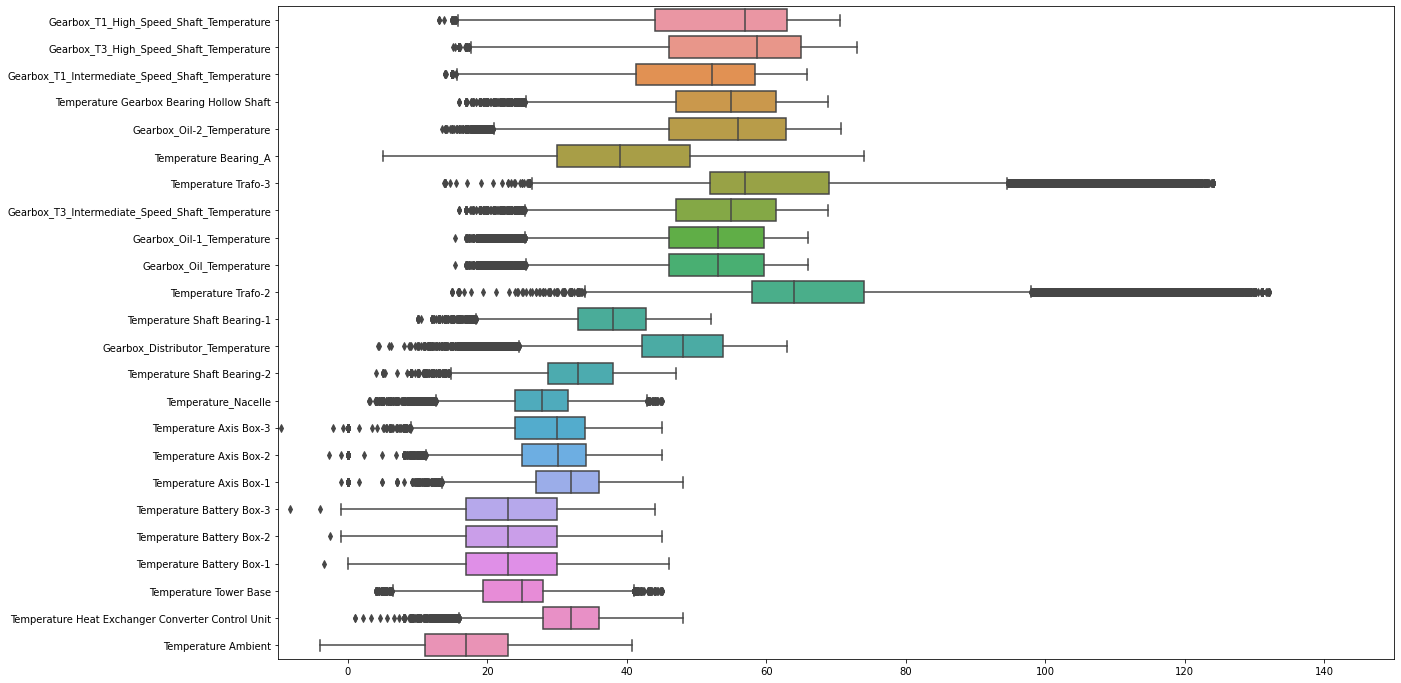

In [15]:
plt.figure(figsize=(20,12))
sns.boxplot(data=features[temperature_features], orient='h')
plt.xlim([-10, 150])

All angles should be in 0-360 degree range. How to deal with 391-1 switches?

In [16]:
n = floor(features[angle_features].min().min() / 360)

if n < 0:
    features[angle_features] += -n * 360
    features[angle_features] = features[angle_features] % 360
    
# (features[angle_features] % 360).describe()

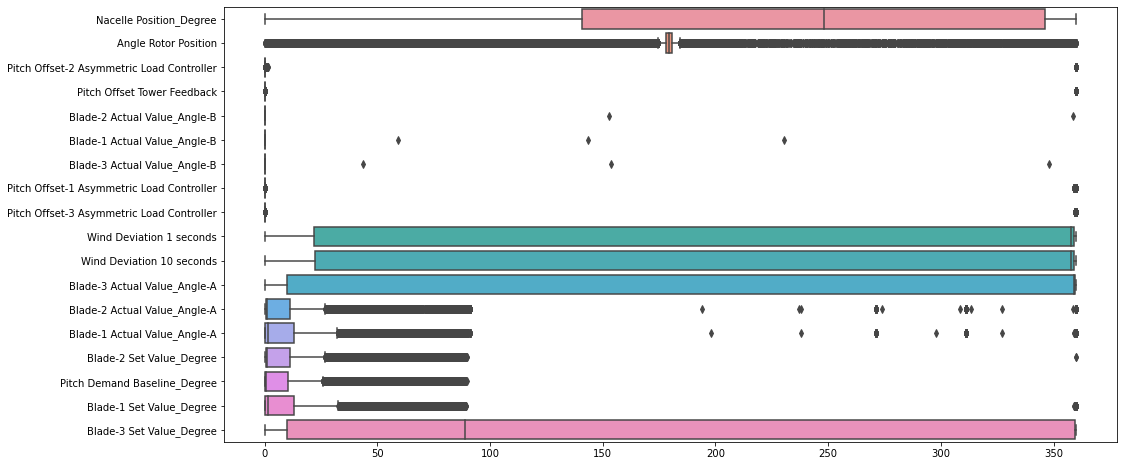

In [17]:
plt.figure(figsize=(16,8))
sns.boxplot(data=features[angle_features], orient='h')
plt.show()

### Removing outliers
When using time series models we cannot simply remove outliers, because they contain time information?

Can we simply replace extreme values with NaNs?

Warning: Dropping NaNs can actually remove important information!

In [18]:
# Remaining features
other = set(features.columns) - set(temperature_features + angle_features)

In [19]:
def find_outliers_iqr(X):
    for col in X.columns:
        feature = X[col]
        q1 = feature.quantile(0.25)
        q3 = feature.quantile(0.75)
        iqr = q3 - q1
        mask = feature.loc[((feature < (q1 - 1.5 * iqr)) | (feature > (q3 + 1.5 * iqr)))].index
        if len(mask) > 0:
            print(col, len(mask))

In [20]:
find_outliers_iqr(features[other])

C:\Users\danie\AppData\Local\Temp\ipykernel_17040\4260805748.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  find_outliers_iqr(features[other])


Tower Deflection 12428
Moment Q Direction 4877
Tower Acceleration Lateral 3770
Proxy Sensor_Degree-135 1306
Reactive Power 1276
Voltage B-N 192
Tower Accelaration Normal Raw 17472
Line Frequency 3841
Converter Control Unit Voltage 3509
External Power Limit 16
Torque 11998
Internal Power Limit 2253
Moment D Direction 2267
Moment Q Filltered 4848
Turbine State 28199
Hydraulic Prepressure 7135
Voltage A-N 177
N-set 1 27784
Voltage C-N 266
Moment D Filtered 2247
Nacelle Revolution 21
Converter Control Unit Reactive Power 1127
Proxy Sensor_Degree-225 785
Tower Acceleration Normal 5865
Proxy Sensor_Degree-315 234
Proxy Sensor_Degree-45 719
Scope CH 4 24241
State and Fault 27521
Torque Offset Tower Feedback 8581
Tower Accelaration Lateral Raw 22531
Operating State 27362


## Exploratory Data Analysis

### Investigating correlations

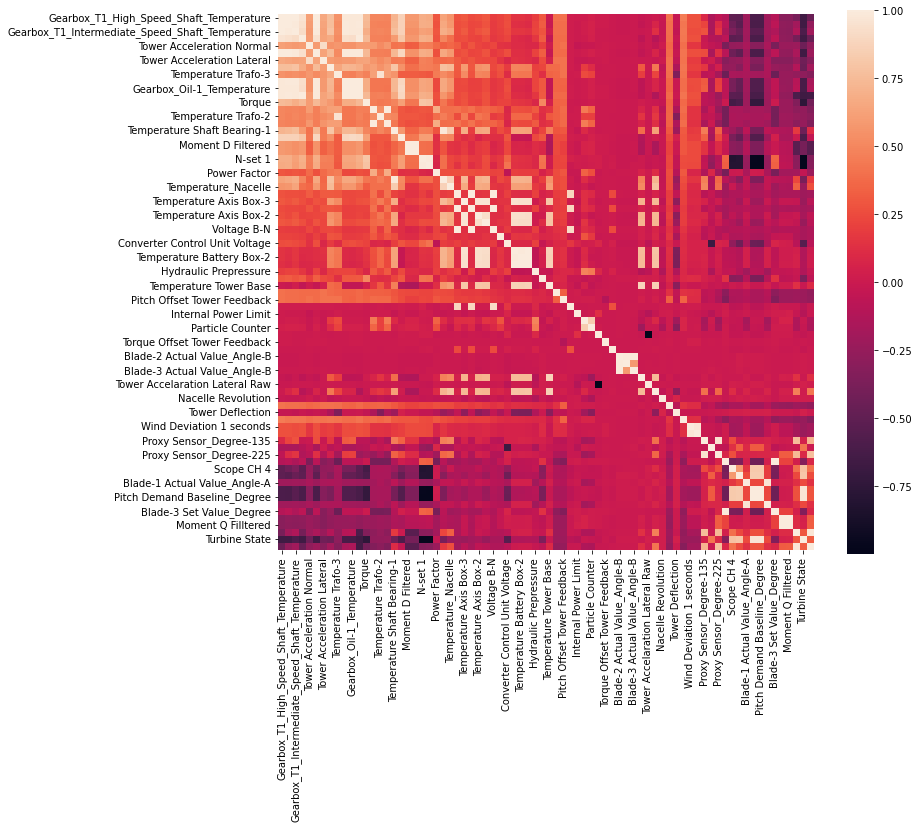

In [23]:
corr_matrix = features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, square=True)
plt.show()

### Investigating Ambient Conditions
Nacelle heats up ~ linearly with ambient temperature, can be hotter than the surrounding air but never is colder. This makes sense, as power electronics inside the nacelle release heat.

Nacelle temperature seems independent of active and reactive power generated by the turbine, as well as torque of the rotor. Correlation between nacelle temperature and generated power could indicated damage in power electronic components (excess heating).

(0.0, 50.0)

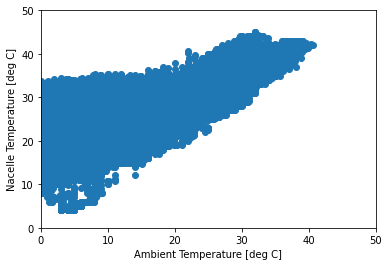

In [24]:
plt.scatter(x=features['Temperature Ambient'], y=features['Temperature_Nacelle'])
plt.xlabel("Ambient Temperature [deg C]")
plt.ylabel("Nacelle Temperature [deg C]")
plt.xlim([0, 50])
plt.ylim([0, 50])

### What influences active power generation?
Surprising: for large torque sometimes no power production

Generation is sometimes limited by internal limit, but almost never by the esternal limit (power grid). 

In [26]:
power.max()

Power(kW)    2779.42334
dtype: float64

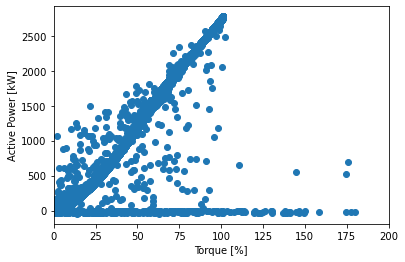

In [27]:
plt.scatter(x=features['Torque'].loc[power.index], y=power)
plt.xlabel("Torque [%]")
plt.ylabel("Active Power [kW]")
plt.xlim([0, 200])
plt.show()

(0.0, 3000.0)

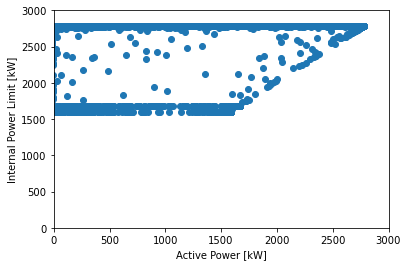

In [28]:
plt.scatter(x=power, y=features['Internal Power Limit'].loc[power.index])
plt.xlabel("Active Power [kW]")
plt.ylabel("Internal Power Limit [kW]")
plt.xlim([0, 3000])
plt.ylim([0, 3000])

In [29]:
# This many times power production is limited by the grid 
(features['External Power Limit'] < features['Internal Power Limit']).sum()

6

### Analysing Conditions When Grid Frequency is far from 50Hz
What is the max margin around 50Hz tolerated by the grid? How does a wind turbine behave when there is no power in the grid?

In [30]:
grid_off = features.loc[power.index].loc[(features['Line Frequency'] < 49.5) | (features['Line Frequency'] > 50.5)].copy()
len(grid_off)

84

### When and why is the active power negative?

Why so many values of power are negative? Is it possible for a wind turbine to consume electricity?

In [33]:
power['Power(kW)'].min()

-48.5966682434082

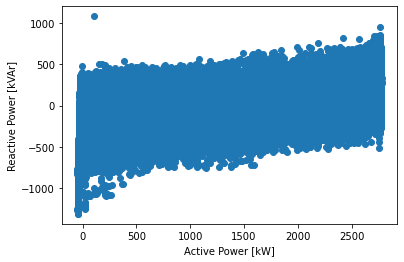

In [34]:
plt.scatter(x=power, y=features['Reactive Power'].loc[power.index])
plt.xlabel("Active Power [kW]")
plt.ylabel("Reactive Power [kVAr]")
plt.show()

Active power is almost always positive while reactive power changes sign.

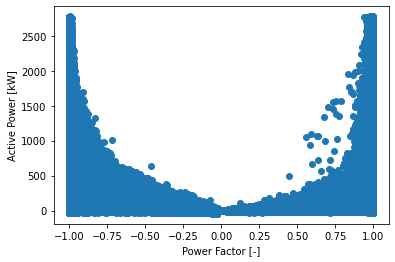

In [35]:
plt.scatter(x=features['Power Factor'].loc[power.index], y=power)
plt.xlabel("Power Factor [-]")
plt.ylabel("Active Power [kW]")
plt.show()

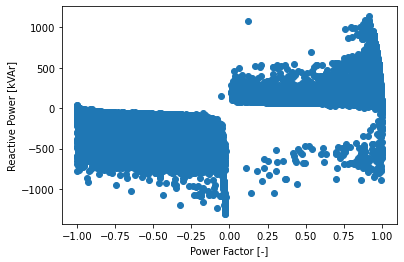

In [36]:
plt.scatter(x=features['Power Factor'], y=features['Reactive Power'])
plt.xlabel("Power Factor [-]")
plt.ylabel("Reactive Power [kVAr]")
plt.show()

### No Wind Conditions
During no wind conditions reactive power is usually zero and active power is negative. This was expected, as without wind there is no power generated while some power is consumed to keep the measuring equipment running, to heat up oil and blades, power the lights and maintain pitch control among others. More complete list of power loads in wind turbines can be found here: http://www.aweo.org/windconsumption.html

In [41]:
no_wind_features = features.loc[features['Torque'] == 0]

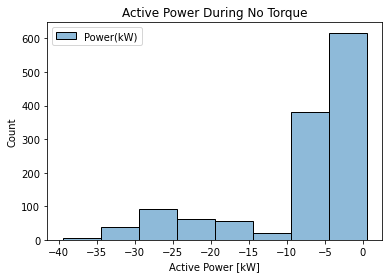

In [42]:
sns.histplot(power.loc[features['Torque'] == 0], binwidth=5)
plt.title("Active Power During No Torque")
plt.xlabel("Active Power [kW]")
plt.show()

<AxesSubplot:xlabel='Reactive Power', ylabel='Count'>

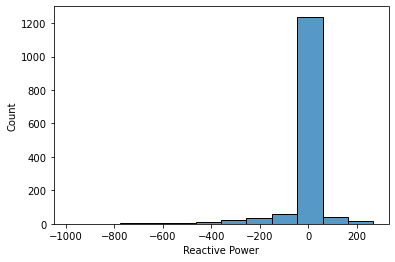

In [43]:
sns.histplot(no_wind_features['Reactive Power'])

### Control System

In [44]:
# We can calculate discrepancy between the set and actual angle of the blade. This way we can investigate if
# delay or noise in the control signal can influence power factor or active power

# SOLVE THE 359-1 DEGREE ISSUE!
(features['Blade-1 Set Value_Degree'] - features['Blade-1 Actual Value_Angle-A']).describe()

count    141498.000000
mean         -0.744932
std          19.091107
min        -359.999823
25%          -0.003159
50%           0.000014
75%           0.003128
max         359.999355
dtype: float64

### Voltage and Reactive Power
Wind turbines are often in remote locations and therefore, they need to maintain line volatage by producing reactive power. Therefore, line-to-neutral voltage and reactive power are correlated. Note that voltage signals are not sinusoidal because of the 10 min sampling frequency.

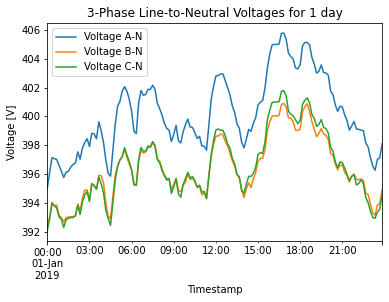

In [46]:
features[['Voltage A-N', 'Voltage B-N', 'Voltage C-N']].iloc[0:6*24].plot()
plt.title("3-Phase Line-to-Neutral Voltages for 1 day")
plt.ylabel("Voltage [V]")
plt.show()

(380.0, 420.0)

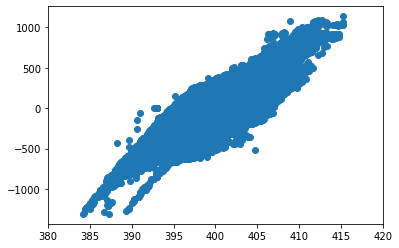

In [47]:
plt.scatter(features['Voltage A-N'], features['Reactive Power'])
plt.xlim([380, 420])

### Generation per month

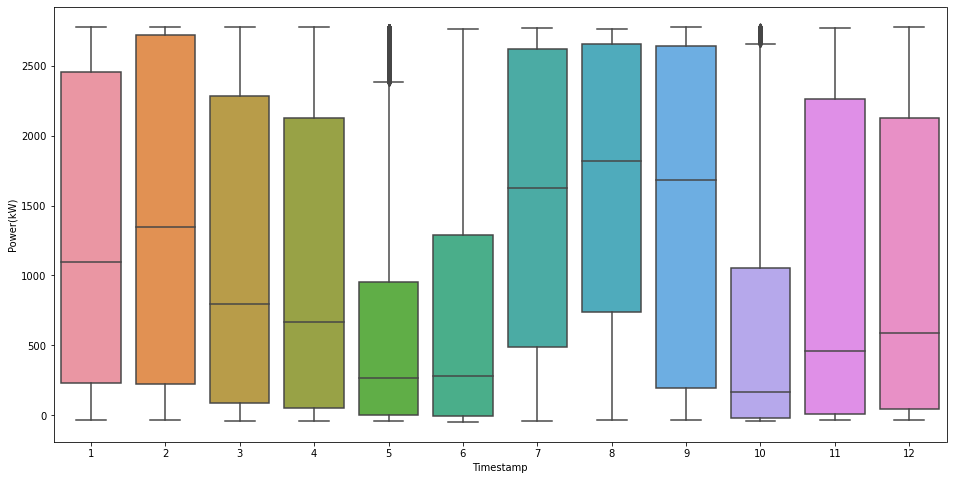

In [49]:
plt.figure(figsize=(16,8))
sns.boxplot(data=power, x=power.index.month, y='Power(kW)') # , orient='h'
plt.show()

Summary of the findings:
- generation is limited by the internal, not the external limit, which means wind turbine switches off due to too high wind speed, rather than grid nto being able to absorb the energy. Grid frequency is very stable and stays within +-0.5 Hz almost at all times.
- reactive power and voltage are correlated, as reactive power is used to maintain line voltage
- ambient temperatures stay between 0 and 40 degrees Celsius with mean around 20 C
- active power is often negative <-- WHY?
- active and reactive power are (weakly) correlated

TODOs:
- fix 359-1 angle issue
- calculate error in provided signal (pitch control)
- understand when wind turbine generates reactive power --> Is it regulated by the power system operator?
- why torque [%] has so many values outside 0-100 range??

## Time Series Decomposition
Wind speed / power time series is expected to have seasonality, as wind speeds tend to be higher in winter. 

Statistical properties of time series such as mean, variance should remain constant over time to call time series is stationary:
- constant mean
- constant variance
- autocovariance that does not depend on time. autocovariance is covariance between time series and lagged time series.

https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda

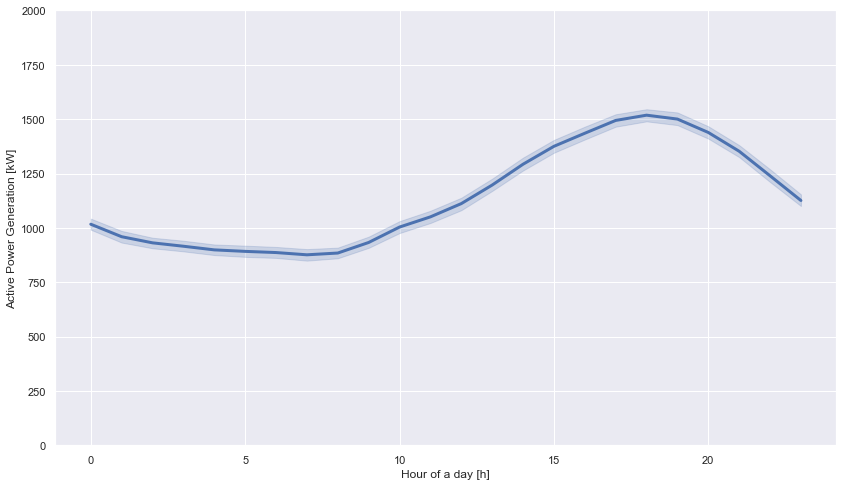

In [50]:
# Seasonal plot showing daily seasonal patterns
# sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=power, x=power.index.hour, y='Power(kW)', lw=3)

plt.xlabel('Hour of a day [h]')
plt.ylabel('Active Power Generation [kW]')
plt.ylim([0, 2000])
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_17040\1814543071.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels, rotation='vertical') # , fontsize=18


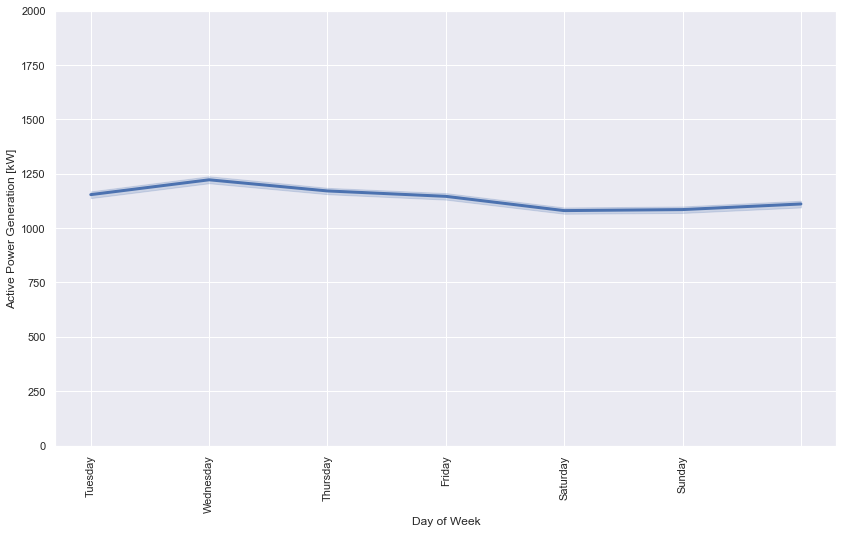

In [51]:
# Seasonal plot showing weekly patterns
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=power, x=power.index.dayofweek, y='Power(kW)', lw=3)

x_ticks_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax.set_xticklabels(x_ticks_labels, rotation='vertical') # , fontsize=18
plt.xlabel('Day of Week')
plt.ylabel('Active Power Generation [kW]')
plt.ylim([0, 2000])
plt.show()

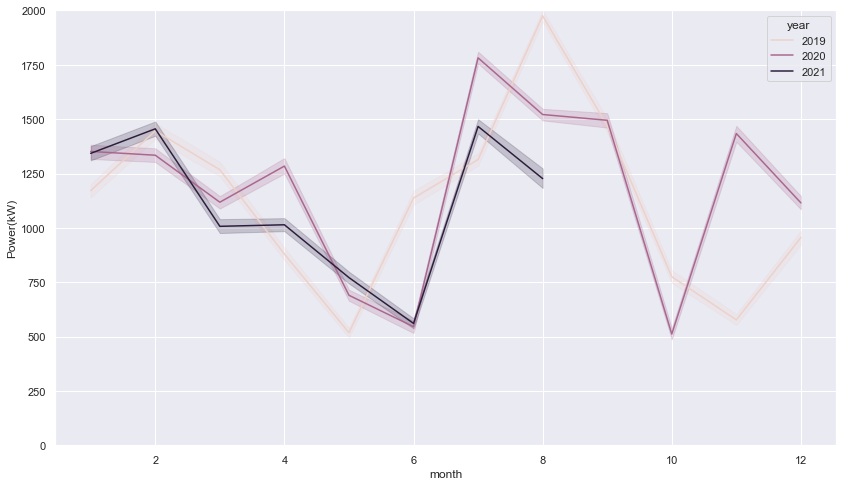

In [52]:
# Seasonal plot showing seasonal patterns
power['month'] = power.index.month
power['year'] = power.index.year

sns.lineplot(data=power, x='month', y='Power(kW)', hue='year', legend='full')
plt.ylim([0, 2000])
plt.show()

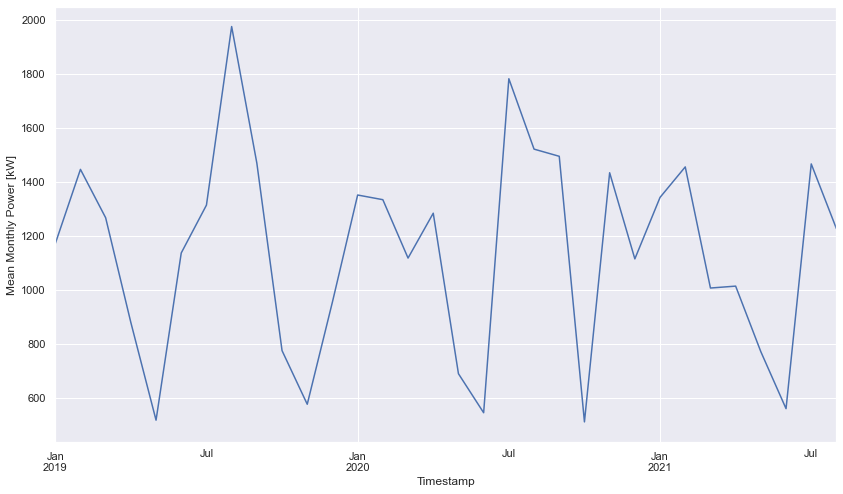

In [53]:
power_monthly = power['Power(kW)'].resample('M').mean()

power_monthly.plot()
plt.ylabel("Mean Monthly Power [kW]")
plt.show()

_Trend_

A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend. There is a trend in the antidiabetic drug sales data shown in Figure 2.2.

_Seasonal_

A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known period. The monthly sales of antidiabetic drugs (Figure 2.2) shows seasonality which is induced partly by the change in the cost of the drugs at the end of the calendar year.

_Cyclic_

A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.

https://otexts.com/fpp3/tspatterns.html

We expect wind power generation to have no trend, or a weak downward trend related to wind turbine degradation. We expect strong seasonal or cyclic component - is the period of generation changes fixed or no? 

Autocorrelation below would linearly decrease in case of a trend which is not the case, as it fluctuates around time series period.

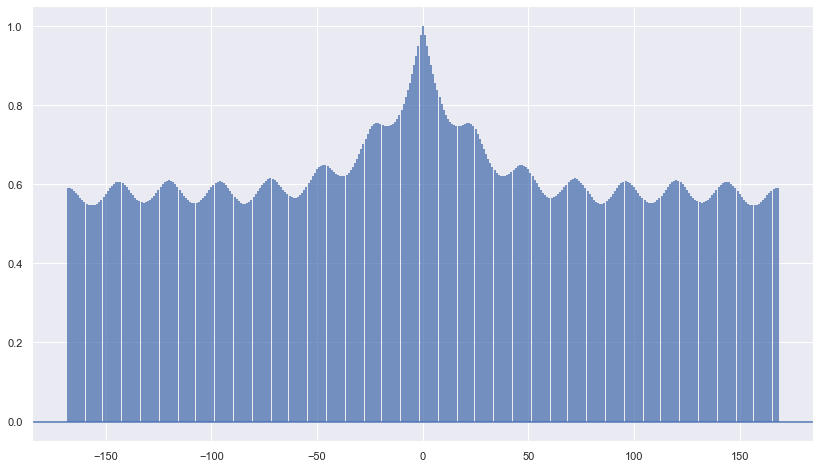

In [58]:
plt.acorr(power['Power(kW)'].resample('H').sum(), maxlags=24*7)
plt.show()

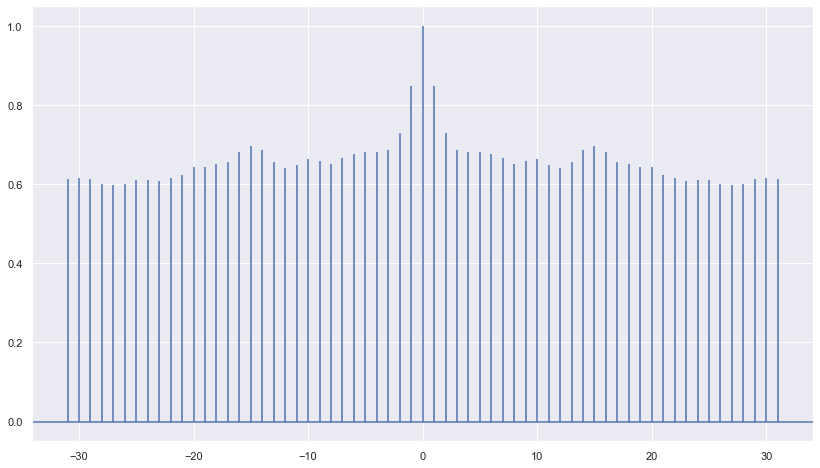

In [55]:
plt.acorr(power['Power(kW)'].resample('D').sum(), maxlags=31)
plt.show()

- Seasonality: describes the periodic signal in your time series.
- Trend: describes whether the time series is decreasing, constant, or increasing over time.
- Noise: describes what remains behind the separation of seasonality and trend from the time series. In other words, it’s the variability in the data that cannot be explained by the model.

https://towardsdatascience.com/time-series-decomposition-in-python-8acac385a5b2

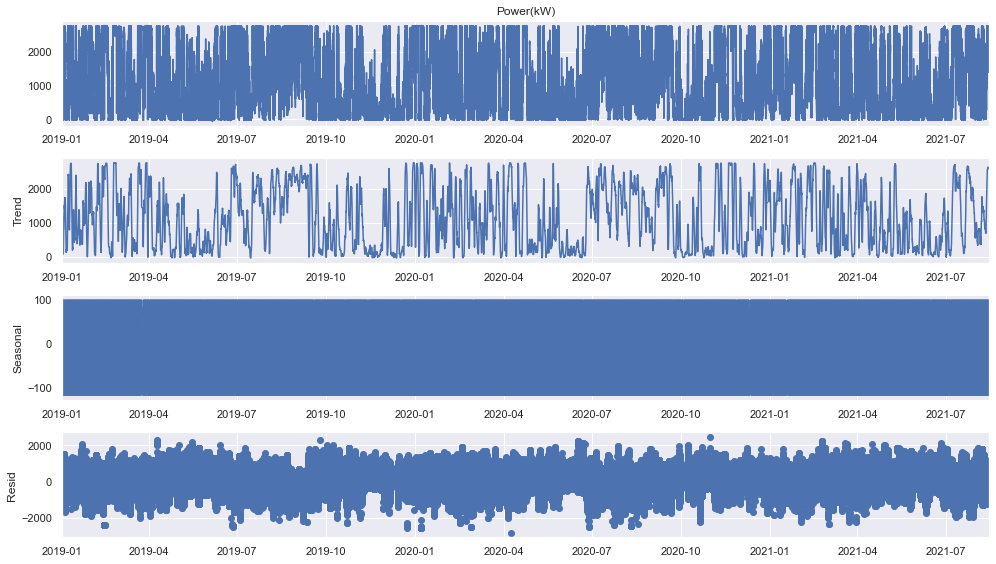

In [59]:
result = seasonal_decompose(power['Power(kW)'], model='additive', period=6*24)  # power_monthly
result.plot()
plt.show()

In [60]:
# plt.figure(figsize=(12, 6))
# result.trend.plot()
# plt.show()

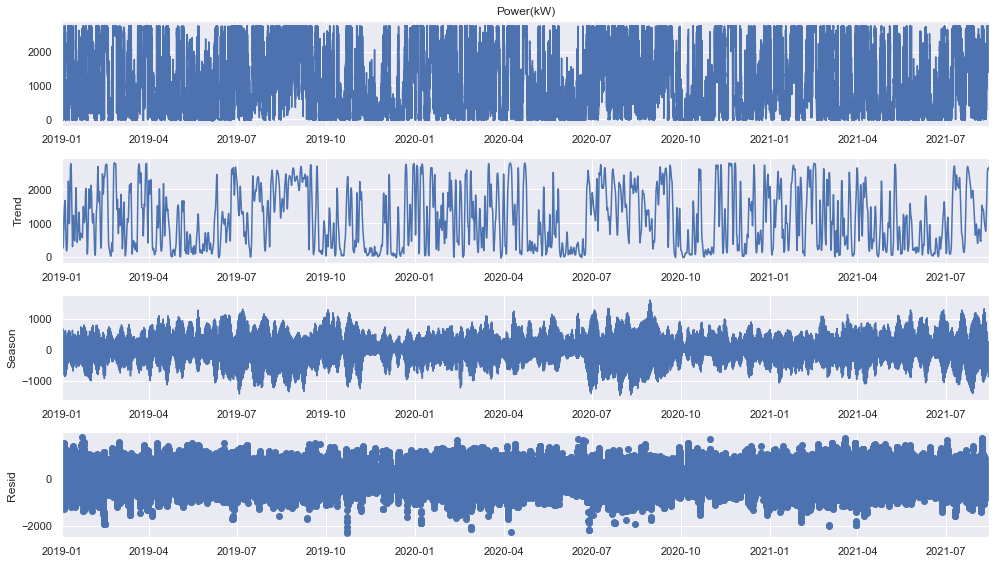

In [61]:
stl = STL(power['Power(kW)'], period=6*24)
res = stl.fit()
res.plot()
plt.show()

In [62]:
6*24*365

52560

<AxesSubplot:xlabel='Timestamp'>

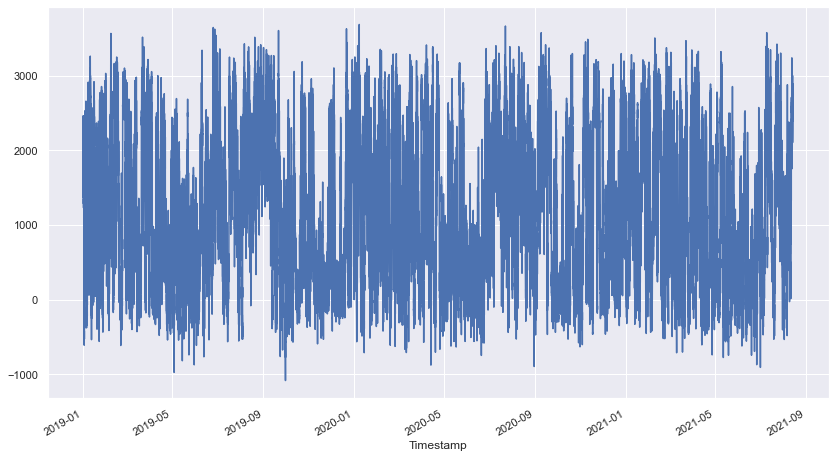

In [63]:
(power['Power(kW)'] - res.seasonal).plot()

<AxesSubplot:xlabel='Timestamp'>

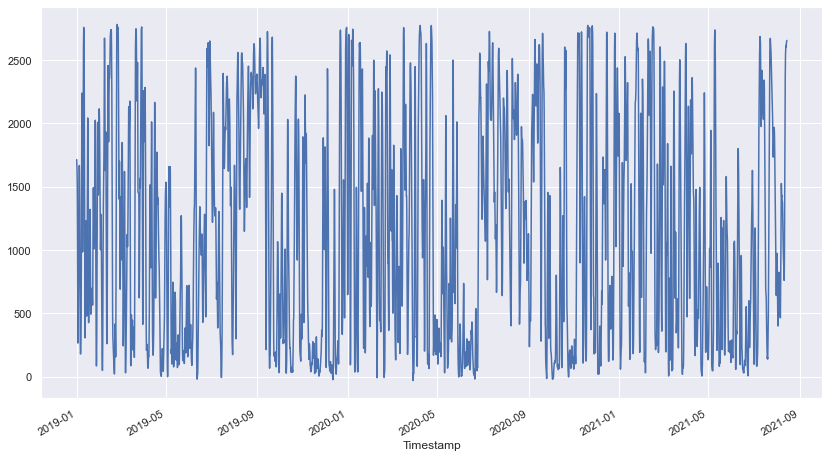

In [64]:
res.trend.plot()

## Feature Engineering

In [ ]:
# Month
# Year

## Modeling
Exploring timeseries methods, as well as regression methods with lagged features.

## Brudnopis

In [ ]:
for date in power['date'].unique():
    series = power['Power(kW)'].loc[str(date)].values
    plt.plot(series, color='#1f77b4', alpha=0.1)
plt.show()

In [ ]:
pal = sns.color_palette("tab10")
pal.as_hex()[0]